In [28]:
%matplotlib inline

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys, os
import csv
import datetime
import numpy as np
import netCDF4
import ast
import scipy
#import scipy.stats
#import json

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

from scipy import stats

import selection_criteria as sc

In [31]:
def ts_to_dt(ts):
    return datetime.datetime.utcfromtimestamp(ts)
def dt_to_ts(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()
def lin2z(array):
    """linear values to dB (for np.array or single number)"""
    return 10 * np.log10(array)

def z2lin(array):
    """dB to linear values (for np.array or single number)"""
    return 10 ** (array / 10.)

In [32]:
filename = {
    "Pun_larda3": '../cloud_collections/cloud_collection_lacros_dacapo_all.csv',
    "Lim_larda3": '../cloud_collections/cloud_collection_lacros_cycare_all.csv',
    "Lei_larda3": '../cloud_collections/cloud_collection_lacros_leipzig_all.csv',
}

larda_names = {
    "Pun_larda3": "lacros_dacapo",
    "Lim_larda3": "lacros_cycare",
    "Lei_larda3": "lacros_leipzig",
}

camp = "Pun_larda3"
# camp = "Lim_larda3"
# camp = "Lei_larda3"

larda_name = larda_names[camp]

In [33]:
data = []
with open(filename[camp], 'r') as f:
#with open('cloud_collection_LEIPZIG_all.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';')
    header = next(reader)
    print("\n".join(sorted(header)))
    for row in reader:
        #data.append(row)
        comp = row[1].replace('_', '')
        if row[0][:14] == comp:
            data.append({k:v for k, v in zip(header, row)})
        else:
            print('corrupted row ', row)
            break

clouds_standard = {
    'layered_all': [],
    'liquid_only': [],
    'ice_producing': []
}

for i, cloud in enumerate(data[:]):
    
    ffcloud = lambda s: float(cloud[s])
    
    dt_begin = ts_to_dt(ffcloud('Begin_Date_Unix'))
    dt_end = ts_to_dt(ffcloud('End_Date_Unix'))
    duration = dt_end-dt_begin
    
    conds = [duration > datetime.timedelta(seconds=20*60), f"{duration}",
             ffcloud('N_Profiles')/(duration.seconds/30.) > 0.8, f"{ffcloud('N_Profiles')*30/duration.seconds:.3f}",
             cloud['Cloud_Run'] in ['layered'], f"{cloud['Cloud_Run']}",
             ffcloud('Cloud_Thickness_MED') < 350, f"{ffcloud('Cloud_Thickness_MED'):.1f}",
#              ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
             ffcloud('CTH_STD') < 150, f"{ffcloud('CTH_STD'):.1f}",
             -40+273.15 < ffcloud('CTT') < 274.15, f"{ffcloud('CTH_STD')+273.15:.1f}",
            ]


    #print(dt_begin, '-', dt_end, ':', h_base, h_top, conds)
    #if cloud["Cloud_Run"] == 'mixed-phase':
        #print(conds)
        #print(cloud['A_Unique_Identifier'] + " critera not matched: " + "   ".join([t for c, t in zip(conds, conds_text) if not c]))
        #print("duration", duration, 'htop', h_top, 'sigma_thick', sigma_thick)
        #print(cloud["Cloud_Run"], 'prof', n_prof, duration.seconds/30,'sigma_cth', sigma_cth, 'iwc_n', iwc_n)

    if all(conds[::2]):
        #print('cloud keys', cloud.keys())
        clouds_standard['layered_all'].append(cloud)
        if ffcloud('IWC_TOP_N')/ffcloud('N_Profiles') < 0.05:
            clouds_standard['liquid_only'].append(cloud)
        else:    
            clouds_standard['ice_producing'].append(cloud)


A_Unique_Identifier
Begin_Date
Begin_Date_Unix
CBH
CBP
CBT
CTH
CTH_AVG
CTH_DIFFSUM
CTH_STD
CTH_autocorr_08_time
CTP
CTT
CTT_MED
Cloud_Run
Cloud_Thickness_AVG
Cloud_Thickness_MED
Cloud_Thickness_STD
Cloud_Type
DIR
Date_Day
Date_Hour
Date_Month
Date_Year
End_Date
End_Date_Unix
ILCR_AVG
ILCR_MED
ILCR_N
ILCR_values
IWC_AVG
IWC_MED
IWC_N
IWC_STD
IWC_TOP_AVG
IWC_TOP_MED
IWC_TOP_N
IWC_TOP_STD
LDR_AVG
LDR_MED
LDR_N
LDR_STD
LDR_TOP_AVG
LDR_TOP_MED
LDR_TOP_N
LDR_TOP_STD
LDR_values
LDRcorr_AVG
LDRcorr_MED
LDRcorr_N
LDRcorr_STD
LDRcorr_TOP_AVG
LDRcorr_TOP_MED
LDRcorr_TOP_N
LDRcorr_TOP_STD
LLH_STD
LWC_AVG
LWC_MED
LWC_N
LWC_STD
N_Drizzle
N_Liquid
N_Melting
N_MixedPhase
N_Profiles
PATH_IWP_AVG
PATH_IWP_STD
PATH_LWP_AVG
PATH_LWP_S_AVG
SNR_TOP_AVG
SNR_TOP_MED
SNR_TOP_N
SNR_TOP_STD
VEL
ZE_AVG
ZE_MED
ZE_N
ZE_STD
ZE_TOP_AVG
ZE_TOP_MED
ZE_TOP_N
ZE_TOP_STD
Z_AVG
Z_AVG_drop
Z_MED
Z_MED_drop
Z_N
Z_N_drop
Z_STD
Z_STD_drop
Z_TOP_AVG
Z_TOP_MED
Z_TOP_N
Z_TOP_STD
Z_TOP_values
Z_top
Z_values
alpha_Hogan_AVG
alpha_

In [34]:
print(len(clouds_standard['liquid_only']))

clouds_standard['liquid_only'] = sorted(clouds_standard['liquid_only'], key=lambda c: c['CTT'], reverse=True)
clouds_standard['ice_producing'] = sorted(clouds_standard['ice_producing'], key=lambda c: c['CTT'], reverse=True)
cloud = clouds_standard['liquid_only'][0]

print(float(cloud['CTT'])-273.15)
toarray = lambda s: np.array(ast.literal_eval(s))


812
0.9812931063844985


identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr
 20190731000145439   0.98  14.10 |  35.9  187.1   38.9  300.0 |  0    0.00
201905062137452060   0.96  21.89 |  70.8  343.0  142.3  270.0 |  5  220.96
 20190712073744439   0.95  11.21 | 105.1  187.1   63.0  450.0 |  1   22.67
202001122208452060   0.94  23.85 | 109.5  233.8  134.1  240.0 | 55 2648.50
 20190602185245533   0.91   7.04 | 138.7  280.6  121.8  390.0 |  1   14.21
201812181535451811   0.91  16.16 |  43.1  155.9   52.9  450.0 |125 4077.15
 20190731003744470   0.90  14.37 |  50.2  218.3   49.2  510.0 |  0    0.00
 20190730223745439   0.88  13.90 |  42.0  187.1   45.6  540.0 |  0    0.00
 20190731143744657   0.87   3.67 |  44.4  249.4   38.2  510.0 |  3   22.32
 20190821023815377   0.87   9.23 |  55.6  218.3   49.5  300.0 |  2   37.47
202001110345141343   0.87  22.40 |  70.7  171.5  117.0  450.0 |  2   90.52
201902271235451967   0.86  21.93 |  30.9  124.7   32.6  420.0 |173 7660.54
202012310052151686   0.8

202003022236142185  -0.83  26.23 |  52.2  280.6   93.4  240.0 |  5  264.77
 20190618203745938  -0.83  22.09 |  92.0  280.6   93.3  420.0 |  1   44.60
202002250735441624  -0.83  22.03 |  99.9  343.0  120.9  390.0 |  8  356.14
 20201218094015938  -0.85  11.34 | 134.9  311.8  111.9  600.0 |  0    0.00
202012190303141125  -0.86   9.79 | 129.7  187.1   98.3  240.0 |  8  158.15
202004222036141530  -0.87  14.56 |  51.7  311.8  109.6  630.0 | 11  323.37
201902131035451967  -0.90  24.60 |  51.7  296.2   96.1  630.0 | 36 1787.96
202006190941151000  -0.90   7.60 |  79.3  155.9  232.5  450.0 |  8  122.73
201902130950451811  -0.92  23.87 |  76.0  155.9   78.0  360.0 |  3  144.53
202002281936142060  -0.94  25.56 |  63.5  280.6  104.5  600.0 |172 8875.86
202002110537152216  -0.97  14.25 |  42.4  187.1   43.7  600.0 |  1   28.80
201904271451451468  -0.98   7.27 |  61.8  249.4   74.4  450.0 |  1   14.67
202004222136141437  -0.99  13.78 |  51.0  187.1   69.5  570.0 |  5  139.11
 20190906183745938  -1.01

 20190628103814751  -2.80  11.80 |  43.2  155.9   43.4  300.0 |  1   23.83
201903160241452715  -2.80  19.84 |  69.8  155.9   24.3  240.0 |120 4807.18
 20190702045615626  -2.84   7.97 |  65.3  311.8   75.8  420.0 |  1   16.11
201901131035451904  -2.84  26.19 |  57.5  249.4   66.7  270.0 | 42 2220.62
202004160736143152  -2.84  10.17 |  30.2  249.4   63.1  630.0 |  1   20.55
 20200730193614595  -2.85  10.66 |  77.0  280.6   90.5  600.0 |  2   43.04
201812311901151437  -2.86  17.32 | 121.5  218.3  130.3  210.0 |  0    0.00
202004160936453276  -2.87  11.61 |  32.4  280.6   59.1  450.0 |  1   23.43
 20200630183614501  -2.87   4.93 |  24.2  155.9   25.0  630.0 |  6   59.73
201901130935452247  -2.89  28.79 | 104.0  311.8  101.0  600.0 |109 6334.88
 20200630153615688  -2.90   6.29 |  55.0  311.8   55.5  600.0 |  9  114.25
202004221036452029  -2.91  19.33 |  30.5  343.0   96.9  600.0 |  2   78.04
202004160836153276  -2.91  10.73 |  28.5  249.4   50.1  600.0 |  1   21.66
201812092035442185  -2.94

201901032147152653  -4.40  17.26 |  59.1  280.6  214.8  420.0 | 88 3065.68
202004031336451125  -4.42  16.29 | 121.0  343.0  135.1  270.0 |  1   32.89
 20200720175914626  -4.42   5.14 |  49.2  218.3   49.8  330.0 |  2   20.74
 20190702073744813  -4.42   5.74 |  76.1  249.4   83.6  330.0 |  1   11.59
 20191103035945813  -4.44  23.67 | 114.2  280.6  128.4  270.0 |  1   48.03
 20200718163614844  -4.44  10.72 |  58.7  249.4   82.5  240.0 |  1   21.65
 20190704000015813  -4.45   5.02 |  32.6  280.6   36.4  360.0 |  1   10.14
201902250537151624  -4.46  11.64 |  64.4  280.6   92.2  330.0 | 52 1223.26
 20200629113615688  -4.47   5.82 |  27.2  155.9   34.0  600.0 |  2   23.49
201909130437441312  -4.50  14.37 |  73.1  249.4   90.1  540.0 |  2   58.33
 20200629193614688  -4.51   4.01 |  34.0  155.9   39.2  270.0 |  2   16.19
201909130537441406  -4.54  15.19 |  46.9  343.0   87.3  600.0 |  1   30.82
 20200717043614657  -4.57   4.75 |  24.3  187.1   35.0  660.0 |  1    9.60
201909222042142092  -4.58

202010021836141343  -7.65  17.50 |  91.0  218.3   91.5  510.0 |  0    0.00
201901040939143276  -7.66  27.34 | 128.4  218.3   80.5  360.0 |  4  220.76
201904071908151873  -7.66  14.44 |  93.2  311.8  103.4  210.0 | 10  291.57
201904080037442154  -7.85  11.27 |  34.2  311.8   58.2  600.0 |  1   22.77
202003080701453869  -7.91  17.73 |  62.9  187.1   71.8  210.0 |  7  250.69
202007292136441686  -7.93  13.09 |  44.8  171.5   54.0  240.0 | 16  422.91
202004150443443245  -7.95  16.08 |  54.1  218.3   72.1  240.0 | 96 3118.89
202010031740152871  -7.97  22.39 |  74.5  218.3   90.1  540.0 |  0    0.00
201903222137452653  -7.98   4.52 |  87.2  218.3   98.4  300.0 |  1    9.11
201910052056442528  -8.07  17.75 |  35.9  280.6   55.9  300.0 |  2   71.92
202010170640142497  -8.07  22.92 |  71.5  155.9   48.0  330.0 |  0    0.00
201901261235452622  -8.10  25.70 | 124.9  218.3   94.2  300.0 |114 5914.42
202010050036152341  -8.13  24.98 | 101.3  311.8   92.9  420.0 |  0    0.00
201902242235442216  -8.14

202004120236443214 -12.80  25.04 |  44.8  249.4   62.5  360.0 |101 5108.43
201902121101145365 -12.83  27.74 |  88.8  280.6  212.0  270.0 |106 5935.34
201906121737452809 -12.86   5.06 |  42.7  124.7   38.8  450.0 |  4   40.82
201811280550154243 -13.05  14.40 |  39.3  187.1   58.5  510.0 |  1   29.10
202002091106155241 -13.24  10.55 |  58.9  187.1   65.3  270.0 |  1   21.30
201901180535444368 -13.25  27.99 |  62.2  187.1   95.9  600.0 |305 17249.73
201902200546453027 -13.34  13.84 | 109.6  311.8  208.6  210.0 |  8  223.64
201909262137454399 -13.39  20.03 | 114.9  218.3   86.8  510.0 | 10  405.79
201901180635444461 -13.44  27.59 |  41.0  249.4   76.7  630.0 |252 14047.29
201812110604143214 -13.52  11.75 | 100.8  280.6  120.2  270.0 | 74 1756.80
201812170135443838 -13.59  30.15 |  58.3  280.6   84.9  300.0 |116 7065.31
201902230935452902 -13.61   7.40 |  88.1  124.7   88.0  480.0 |  1   14.94
201901140836454181 -13.67  18.49 | 138.0  311.8  159.5  300.0 | 55 2052.44
201907210446152434 -13.

201910031901155334 -26.12  19.80 |  88.6  187.1   91.6  240.0 | 92 3688.94
201910220254155802 -26.20  22.36 |  90.4  343.0   97.4  240.0 | 28 1270.63
202003092336146176 -26.21  24.54 |  38.3  109.1   54.4  270.0 | 38 1882.82
201812091535456332 -26.21  32.02 |  82.2  155.9   36.2  300.0 | 60 3878.09
201910221342445459 -26.25  23.02 |  86.9  187.1   63.0  420.0 | 43 2001.31
202009300242144087 -26.28  22.26 | 110.4  218.3   60.0  540.0 |  0    0.00
202012211536156082 -26.42  28.64 |  73.9   93.5   64.6  270.0 | 36 2081.72
202007280936154617 -26.53  31.51 |  71.9  249.4   50.3  270.0 | 54 3434.85
202011201807146457 -26.63  28.48 |  87.5   93.5   35.0  330.0 | 92 5288.76
201901062235444243 -26.90  16.70 | 127.3  218.3   96.5  510.0 | 25  842.79
201911041637455116 -27.10  28.46 | 123.3  187.1   57.3  330.0 |140 8072.13
202011201836146425 -27.25  27.73 | 136.4  124.7   75.3  360.0 | 91 5093.95
201903270439156987 -27.29  39.93 |  97.1  343.0  117.3  570.0 |117 9439.18
202001151206454305 -27.29

202001061000141593   0.56   1.00 |  56.7  280.6   55.7  270.0 |  0    0.00
 20200822103615377   0.54   1.00 |  44.1  124.7   70.3  330.0 |  2    4.04
201812181208441499   0.53   1.00 | 119.7  124.7   40.1  180.0 |  8   16.15
 20190821050244345   0.52   1.00 |  57.5  218.3   56.5  240.0 |  1    2.03
201903020135442060   0.49   1.00 | 125.4  280.6  121.5  570.0 |  4    8.08
202011031636141593   0.48   1.00 |  38.0  343.0   45.3  630.0 |  0    0.00
 20181203081445595   0.47   1.00 | 103.5  218.3   67.9 2520.0 |  1    2.02
201901032249141686   0.45   1.00 |  33.9  311.8   54.3  480.0 |  7   14.13
201902131635442372   0.44   1.00 |  86.0  343.0  157.5  270.0 |  1    2.02
 20200617233644501   0.41   1.00 |  30.8  187.1   34.5  240.0 |  4    8.07
 20200819093615844   0.40   1.00 |  81.3  343.0  128.0  600.0 |  0    0.00
 20200821050345720   0.35   1.00 |  75.6  187.1   51.8  300.0 |  6   12.12
201903121435451187   0.34   1.00 |  44.0  218.3   44.9  660.0 |  2    4.04
201901172208451873   0.34

201904271537441593  -1.27   1.00 |  85.2  343.0   82.4  630.0 |  1    2.02
201903191438141437  -1.31   1.00 |  98.2  343.0  184.9  570.0 | 40   80.75
 20200618000015533  -1.32   1.00 |  32.9  249.4   34.2  330.0 |  3    6.06
 20200730153615439  -1.35   1.00 |  56.8  218.3   50.2  630.0 |  5   10.09
201812180956441593  -1.36   1.00 |  27.3  187.1   47.7  240.0 | 91  183.71
201903191337441655  -1.41   1.00 |  83.4  343.0  108.1  390.0 | 86  173.61
202010292336142185  -1.45   1.00 |  49.3  249.4   87.1  240.0 |  0    0.00
 20200618003615595  -1.45   1.00 |  70.9  343.0   91.2  540.0 |  4    8.08
201903230453451749  -1.47   1.00 |  72.8  155.9   80.6  360.0 |  8   16.16
 20190906073744657  -1.57   1.00 |  40.9  249.4   59.7  630.0 |  1    2.03
202003151108442590  -1.57   1.00 |  95.3  311.8  236.2  180.0 |  1    2.02
 20190504193745688  -1.57   1.00 |  44.3  280.6   98.1  540.0 |  2    4.04
 20200704083744626  -1.58   1.00 |  24.6  280.6   59.6  390.0 |  0    0.00
 20190906153744876  -1.60

201910052037451624  -3.82   1.00 |  92.9  343.0  106.9  390.0 | 17   34.44
201903300337442341  -3.83   1.00 | 129.1  311.8  148.4  510.0 | 47   94.96
201906131537441031  -3.83   1.00 |  48.1  280.6   57.0  570.0 |  2    4.04
202009131509141374  -3.84   1.00 | 100.3  311.8  128.0  210.0 |  1    2.02
202004251836141437  -3.85   1.00 |  33.9  218.3  105.7  510.0 |  1    2.02
202004011653452154  -3.85   1.00 |  87.7  343.0  358.2  360.0 |  5   10.09
201812051338141593  -3.85   1.00 |  99.2  280.6  114.9  540.0 |  3    6.06
 20200630003615533  -3.87   1.00 |  35.2  124.7   31.8  510.0 |  3    6.06
 20200717063614595  -3.87   1.00 |  59.7  249.4   39.5  330.0 |  2    4.04
 20200629133615657  -3.88   1.00 |  34.0  124.7   48.8  510.0 |  4    8.07
 20200629203614564  -3.89   1.00 |  39.0  187.1   60.2  480.0 |  1    2.02
202005121446141312  -3.90   1.00 |  74.1  249.4   78.7  360.0 |  4    8.07
201909162237451468  -3.97   1.00 |  79.0  202.7   88.4  240.0 | 37   74.95
 20200630000015564  -3.97

201904080137452029  -6.83   1.00 |  29.2  187.1   40.5  270.0 |  1    2.02
201901031954453058  -6.91   1.00 |  60.4  124.7   86.3  390.0 | 10   20.19
202003080549143713  -6.92   1.00 |  46.0  187.1   87.4  390.0 | 10   20.20
201906052037452154  -6.94   1.00 |  54.3  249.4   96.5  180.0 |  1    2.02
201901210035452403  -6.97   1.00 |  88.3  249.4  147.6  450.0 |  2    4.04
201812050652151780  -6.99   1.00 |  95.3  343.0   97.8  420.0 | 23   46.43
201902162235443214  -7.02   1.00 |  68.5  311.8  109.6  600.0 |267  539.00
201902162203153245  -7.08   1.00 |  65.5  327.4  102.5  240.0 | 77  155.44
202009071236152247  -7.12   1.00 |  45.7  124.7   33.9  330.0 |  1    2.02
201903222108152466  -7.12   1.00 |  85.9  233.8  111.2  240.0 |  2    4.04
201910012202451655  -7.21   1.00 |  66.3  311.8   87.2  300.0 |  4    8.10
201910021238142123  -7.26   1.00 |  96.2  187.1   69.5  570.0 |  5   10.15
201907021741151218  -7.27   1.00 |  64.2  218.3   73.8  300.0 |  6   12.15
202011011541153869  -7.29

201909262137454399 -13.39   1.00 | 114.9  218.3   86.8  510.0 | 10   20.26
201901180635444461 -13.44   1.00 |  41.0  249.4   76.7  630.0 |252  509.15
201812110604143214 -13.52   1.00 | 100.8  280.6  120.2  270.0 | 74  149.51
201812170135443838 -13.59   1.00 |  58.3  280.6   84.9  300.0 |116  234.32
201902230935452902 -13.61   1.00 |  88.1  124.7   88.0  480.0 |  1    2.02
201901140836454181 -13.67   1.00 | 138.0  311.8  159.5  300.0 | 55  111.03
201907210446152434 -13.69   1.00 |  92.4  249.4   60.7  450.0 | 42   85.22
202004011136153962 -13.79   1.00 |  33.3  155.9   37.9  210.0 | 26   52.49
201903240553143931 -13.87   1.00 |  96.1  343.0  105.8  390.0 |  2    4.04
201909071306153526 -13.99   1.00 |  20.8  155.9   99.8  240.0 | 33   66.73
202001050020443432 -14.31   1.00 | 129.0  311.8  125.7  210.0 | 75  151.50
201901140958454430 -14.49   1.00 |  76.6  249.4  136.4  330.0 |  9   18.17
201812041252152622 -14.68   1.00 |  84.9  249.4   86.4  240.0 |100  201.87
202003210005444305 -14.89

201903032254155303 -31.09   1.00 | 104.8  249.4   90.0  360.0 | 45   90.84
202003172102457486 -31.15   1.00 |  70.5  249.4   86.1  300.0 | 10   20.19
202003172136147860 -31.36   1.00 |  70.0  280.6   79.5  300.0 | 41   82.77
201902030143448078 -31.57   1.00 |  96.9  343.0  102.8  210.0 | 45   90.90
202011130951155958 -31.57   1.00 | 100.3  249.4   93.0  330.0 |  7   14.13
201910061109145833 -31.60   1.00 |  86.9  155.9   98.8  240.0 | 21   42.47
201903201237447423 -31.75   1.00 |  68.2  187.1   54.1  420.0 | 24   48.45
201901221152445490 -31.76   1.00 | 126.6  249.4  128.3  240.0 |105  211.97
201906161937457486 -31.86   1.00 |  90.7  296.2  120.8  300.0 | 32   64.60
202011182249447267 -32.59   1.00 | 128.6  280.6   99.9  480.0 | 16   32.30
202011190240447143 -32.85   1.00 |  92.6  343.0   69.9  570.0 |268  541.25
201906162041157641 -32.90   1.00 | 133.2  343.0  122.7  390.0 |157  316.94
202005081544456051 -33.04   1.00 |  51.7  249.4  101.6  300.0 | 13   26.24
202006151646455864 -33.13

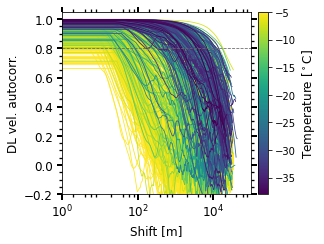

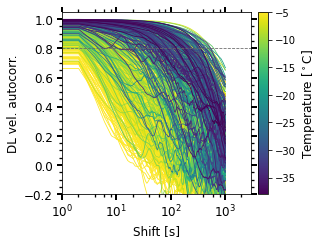

In [35]:

def plot_autocorr(clouds, hvel_corr=None):
    fig, ax = plt.subplots(figsize=[4.6,3.5])

    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

    print('identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr')
    for cloud in clouds:

        ctt = float(cloud['CTT'])-273.15
        if hvel_corr:
            vel = max(float(cloud['VEL']),0.1)
        else:
            vel = 1
        
        autocor_time = toarray(cloud['v_dl_autocor_time'])
        autocor_coeff = toarray(cloud['v_dl_autocor_coeff'])
        
        autocorr_lt_thres = np.where(autocor_coeff > 0.8)[0]
        i_above_thres = autocorr_lt_thres[-1] if len(autocorr_lt_thres) > 0 else 0
        autocorr_at_thres = autocor_time[i_above_thres]*vel if len(autocor_time) > 0 else 0
        
        cth_std = float(cloud['CTH_STD'])
        thick_med = float(cloud['Cloud_Thickness_MED'])
        thick_std = float(cloud['Cloud_Thickness_STD'])
        ct_ac = float(cloud['CTH_autocorr_08_time'])

        print(f"{cloud['A_Unique_Identifier']:>18} {ctt:6.2f} {vel:6.2f} |\
{cth_std:6.1f} {thick_med:6.1f} {thick_std:6.1f} {ct_ac:6.1f} |\
{i_above_thres:3} {autocorr_at_thres:7.2f}")
        ax.plot(autocor_time*vel, autocor_coeff, 
                linewidth=0.8,
                color=cmap(norm(ctt)))

    ax.axhline(0.8, linewidth=0.8, color='dimgrey', linestyle='--')
    ax.set_xscale('log')
    

    if hvel_corr:
        ax.set_xlim([1e0, 1e5])
        ax.set_xlabel('Shift [m]', fontsize=12)
    else:
        ax.set_xlim([1e0, 3e3])
        ax.set_xlabel('Shift [s]', fontsize=12)
    ax.set_ylabel('DL vel. autocorr.', fontsize=12)
    ax.set_ylim([-0.2, 1.05])

    #ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    #ax.legend(fontsize=12)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.tick_params(axis='both', which='both', right=True, top=True)
    ax.tick_params(axis='both', which='major', labelsize=12,
                   width=2, length=5.5)
    ax.tick_params(axis='both', which='minor', width=1.3, length=3)

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    plt.gcf().add_axes(ax_cb)
    cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
    
    return fig, ax

fig, ax = plot_autocorr(clouds_standard['liquid_only'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation.png'
fig.savefig(fname, dpi=250)

print('================================')
fig, ax = plot_autocorr(clouds_standard['liquid_only'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_s.png'
fig.savefig(fname, dpi=250)

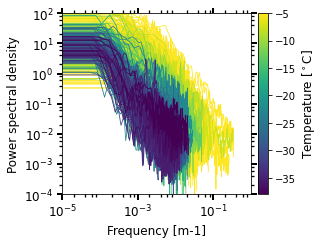

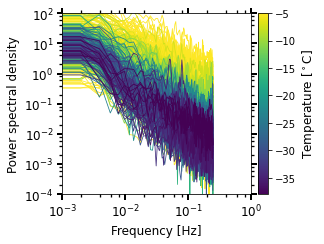

In [36]:

def plot_periodogram(clouds, hvel_corr=None):
    fig, ax = plt.subplots(figsize=[4.6,3.5])

    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

    for cloud in clouds[:]:

        ctt = float(cloud['CTT'])-273.15
        if hvel_corr:
            vel = max(float(cloud['VEL']),0.1)
        else:
            vel = 1
        #print(cloud['A_Unique_Identifier'], ctt, vel)
        period_f = toarray(cloud['v_dl_period_f'])
        period_Pxx = toarray(cloud['v_dl_period_Pxx'])
        ax.plot(period_f/vel, np.abs(period_Pxx), 
                linewidth=0.8,
                color=cmap(norm(ctt)))

    ax.set_yscale('log')
    ax.set_xscale('log')

    if hvel_corr:
        ax.set_xlim([1e-5, 1e0])
        ax.set_xlabel('Frequency [m-1]', fontsize=12)
    else:
        ax.set_xlim([1e-3, 1e0])
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
    ax.set_ylabel('Power spectral density', fontsize=12)
    ax.set_ylim([1e-4, 1e2])

    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    #ax.legend(fontsize=12)
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12))
    ax.tick_params(axis='both', which='both', right=True, top=True)
    ax.tick_params(axis='both', which='major', labelsize=12,
                   width=2, length=5.5)
    ax.tick_params(axis='both', which='minor', width=1.3, length=3)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    plt.gcf().add_axes(ax_cb)
    cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
    
    return fig, ax


fig, ax = plot_periodogram(clouds_standard['liquid_only'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_periodogram(clouds_standard['liquid_only'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_s.png'
fig.savefig(fname, dpi=250)

# fig.savefig('{}_dl_vel_spectrum.png'.format(time_interval[0].strftime("%Y%m%d_%H%M")), dpi=250)
# fname = '../plots/v_timeseries/dl_vel_autocorrelation.png'
# fig.savefig(fname, dpi=250)

identifier ctt hvel | cth_std thick_med thick_std ct_ac | indx vel_autocorr
201903312001152279   0.98  25.26 |  81.1  280.6   93.2  210.0 |  0    0.00
202001162335442559   0.96  24.00 |  36.7  187.1   61.0  270.0 | 64 3101.16
202006011047451561   0.78  22.13 | 100.5  187.1   95.0  480.0 |  4  178.69
202012192205141811   0.31  22.90 |  96.1  311.8  121.3  270.0 | 27 1248.22
202008210558141000  -0.11  26.19 |  98.0  343.0  118.7  360.0 |144 7620.61
202010300336151749  -0.23  30.35 |  66.3  343.0   83.6  600.0 |  0    0.00
201904240537441904  -0.69  22.90 |  94.9  311.8   80.5  570.0 |  1   46.27
202003170740141437  -0.78  20.07 |  87.6  187.1   83.1  420.0 | 66 2676.87
 20190531063744907  -0.86   3.95 |  53.5  280.6  134.1  600.0 |  5   39.93
201903120937441312  -1.05   5.22 |  59.2  155.9   56.9  270.0 | 33  347.49
202002101135451998  -1.19  10.15 |  94.0  218.3  103.4  450.0 |  4   81.94
202010101736141717  -1.24  30.54 |  58.6  124.7  100.4  210.0 |  0    0.00
 20190906173745907  -1.2

202004150836153027  -6.32  13.26 |  38.6  249.4   77.9  480.0 |  1   26.77
202009231136152466  -6.33  28.96 |  62.6  327.4  104.5  420.0 |  1   58.47
 20200716043614844  -6.36   1.69 |  29.8  249.4   45.0  630.0 | 16   54.66
 20200715113615782  -6.37   5.42 | 119.5  296.2  153.0  240.0 |  8   87.50
 20200720123615907  -6.37   4.33 |  28.2  155.9   68.2  570.0 |  2   17.49
202004250236151780  -6.37   1.17 |  41.8  311.8   79.7  600.0 |  5   11.77
 20200716093615813  -6.38   1.66 |  30.8  187.1   44.1  630.0 |  3   10.04
201906221037441717  -6.41  15.13 | 105.5  233.8  114.3  210.0 | 22  672.17
 20200720133615844  -6.43   4.61 |  41.2  249.4   49.3  630.0 |  3   27.91
202004240236151499  -6.44  11.29 |  48.2  218.3   48.0  330.0 |  3   68.41
201901051804141780  -6.47  29.62 |  98.4  311.8  177.6  270.0 | 38 2272.06
202007271005142310  -6.51  25.84 |  26.8  343.0  134.8  240.0 |  1   52.17
202010201336151406  -6.61  11.40 |  99.8  343.0  146.7  540.0 |  0    0.00
201905290000151842  -6.63

201811302108152933 -13.44  13.77 | 140.8  187.1   80.2  870.0 |  2   55.59
202009031636142653 -13.50   4.97 |  41.9  124.7   27.0  360.0 |  1   10.03
201907040837442559 -13.52  10.22 |  51.6  249.4   38.9  600.0 |  1   20.74
201903061435452933 -13.53   9.57 |  62.6  218.3  492.5  540.0 |  2   38.63
201902230835452871 -13.58   6.99 | 105.3  187.1  158.5  600.0 |  0    0.00
202005020458144368 -13.59  21.32 |  98.5  187.1   87.7  270.0 |  1   43.08
201908151303153432 -13.60  15.21 |  62.7  218.3   59.1  300.0 | 79 2429.45
201909042137453993 -13.62  12.71 |  45.5  280.6   87.3  600.0 |  0    0.00
201905280137451873 -13.65   4.01 | 109.1  296.2  248.8  630.0 |  4   32.42
201910010005442466 -13.77  11.52 |  40.7  280.6  134.1  270.0 |  3   70.13
202002102135444492 -13.80  21.02 | 113.9  249.4   59.5  570.0 | 20  848.53
201902021740155365 -14.06  19.14 |  62.3  280.6  201.7  300.0 | 67 2588.33
201909041743143775 -14.07  13.81 |  33.3  343.0   83.3  540.0 |  1   27.97
202001071935443588 -14.18

201905020601454056 -26.14  19.64 |  54.4  218.3  406.1  300.0 |  1   39.68
201910051345144991 -26.21  15.90 |  83.7  249.4  147.8  330.0 |  1   32.27
201812180058456114 -26.61  30.66 |  54.3  343.0   59.1  330.0 |103 6380.06
201812041342444866 -26.93  21.13 |  39.0  218.3  283.3  510.0 |  1   42.65
201902250035456238 -26.95  32.09 |  65.3  343.0   32.0  630.0 |  0    0.00
201901162047456363 -26.97  25.35 |  49.2  124.7  227.8  270.0 | 38 1944.96
202008130157443682 -27.01  14.67 |  46.2  218.3  329.7  270.0 |  3   88.89
201910281837453900 -27.01  19.68 |  99.7  218.3  115.1  330.0 |  2   79.74
202004060438146768 -27.02  29.06 |  67.9  311.8  135.0  210.0 | 13  763.41
202007280852444617 -27.04  32.68 |  38.2  218.3   51.7  420.0 |128 8444.09
202004192236145116 -27.08  19.87 |  94.2  280.6  160.5  600.0 |  1   40.11
201812200247457049 -27.17  17.55 |  82.2  249.4  112.3  420.0 | 40 1417.75
201812041313154991 -27.21  22.01 |  42.7  249.4   48.1  240.0 |  1   44.43
201901021352445022 -27.58

202003091043152310  -3.78   1.00 | 149.0  249.4   83.6  480.0 |177  357.32
201901231458152216  -3.80   1.00 |  68.6  280.6  106.7  270.0 |  1    2.02
201812170539441031  -3.81   1.00 |  95.3  218.3  112.5  480.0 |  0    0.00
202011142036142216  -3.82   1.00 |  75.4  311.8   56.4  210.0 | 74  149.39
202002280836151780  -3.84   1.00 |  61.4  343.0   85.9  270.0 |  9   18.17
 20190613034015751  -3.88   1.00 |  60.4  218.3   97.3  480.0 |  1    2.02
 20190919063814782  -3.93   1.00 |  55.6  233.8   63.8  210.0 |  0    0.00
202010142236142092  -4.00   1.00 | 125.8  343.0  142.6  180.0 |  0    0.00
202002051535451873  -4.06   1.00 |  62.5  280.6  124.1  240.0 |  3    6.06
202002272336141780  -4.07   1.00 |  54.2  343.0   76.5  210.0 |  0    0.00
 20200708065915751  -4.10   1.00 |  48.6  155.9   66.7  240.0 |  1    2.02
202003311306451936  -4.11   1.00 |  68.7  249.4  190.9  240.0 | 71  143.33
 20200707103615782  -4.14   1.00 |  66.9  343.0   79.9  660.0 |  1    2.02
202001140935452092  -4.14

201907050938142279  -7.96   1.00 | 108.5  311.8  165.6  660.0 |  1    2.02
202011211904442777  -8.12   1.00 | 100.8  311.8  289.2  240.0 |  1    2.02
201905121437442123  -8.22   1.00 | 105.4  343.0   95.5  330.0 | 16   32.35
201907051237442622  -8.35   1.00 |  82.7  311.8  111.5  420.0 |  0    0.00
201903230237443027  -8.38   1.00 |  41.7  249.4  271.2  600.0 |  3    6.06
201901112001451561  -8.41   1.00 | 131.1  343.0  146.1  240.0 |  1    2.02
201904302137451967  -8.48   1.00 |  76.6  343.0  138.4  570.0 |  8   16.15
202010031843442777  -8.50   1.00 | 112.8  249.4  194.2  540.0 |  0    0.00
201812132035442185  -8.69   1.00 |  55.1  311.8  123.2  240.0 |  3    6.06
201907031637451250  -8.73   1.00 |  63.3  218.3   51.1  240.0 |  6   12.15
201905281237441468  -8.95   1.00 |  56.7  187.1   73.9  510.0 |  2    4.04
202004070636143650  -8.98   1.00 |  80.4  280.6  285.8  420.0 |  2    4.04
201907041937452060  -8.98   1.00 |  74.0  311.8  161.7  480.0 | 88  178.25
202007062049141624  -9.00

202003120636144898 -17.54   1.00 |  81.1  343.0  210.8  210.0 |  0    0.00
202006221736143619 -17.56   1.00 |  39.6  343.0  186.9  360.0 |  1    2.02
201910020657154087 -17.72   1.00 |  50.2  280.6   87.1  390.0 | 17   34.49
202005280536143307 -17.82   1.00 |  88.8   93.5   83.1  390.0 |  1    2.02
201903191142444648 -17.94   1.00 |  99.9  187.1  117.1  330.0 | 59  119.11
201902241135453495 -17.96   1.00 |  92.3  249.4   91.9  630.0 |  1    2.02
201902241035453276 -18.06   1.00 |  54.9  343.0   64.4  630.0 |  2    4.04
201910192237454929 -18.07   1.00 | 106.9  249.4  141.7  270.0 |113  228.89
201902240806453495 -18.39   1.00 |  61.2  249.4   73.7  240.0 | 25   50.47
201902240935453495 -18.43   1.00 |  57.1  202.7  546.3  630.0 |  9   18.17
201909020508453931 -18.47   1.00 | 102.2  280.6   41.4  240.0 |  5   10.15
202007110436142559 -18.89   1.00 |  86.0  218.3   62.1  390.0 | 15   30.31
201903181435454492 -18.92   1.00 |  36.3  218.3  191.3  210.0 |  2    4.04
201903181335454430 -18.93

201812270139156020 -29.90   1.00 |  64.0  218.3  152.1  300.0 |  1    2.02
201901130238156987 -29.95   1.00 |  74.1  311.8  159.5  540.0 |  3    6.06
202004230153156332 -30.07   1.00 |  80.6  187.1   69.3  240.0 |  1    2.02
202002280246457049 -30.10   1.00 | 101.4  280.6  121.6  480.0 |  1    2.02
201812181038146768 -30.24   1.00 |  83.6  265.0  106.8  540.0 |  0    0.00
201902102035445958 -30.48   1.00 |  96.5  343.0  142.9  450.0 |  1    2.02
201906290937444212 -30.51   1.00 |  51.5  311.8  222.9  240.0 |  2    4.04
201905040937445895 -30.54   1.00 |  62.8  343.0  421.7  600.0 |  1    2.02
202002251101447922 -30.73   1.00 |  30.0  218.3   59.4  300.0 |116  234.17
201812202335446987 -30.84   1.00 |  52.4  249.4   25.2  270.0 |111  224.08
201901020605444929 -30.98   1.00 |  76.3  343.0  133.8  240.0 |126  254.58
202002070002457486 -31.13   1.00 |  78.8  218.3  120.3  300.0 |  0    0.00
201903211937456924 -31.15   1.00 |  15.2  155.9   27.8  300.0 |128  258.40
202005082336145989 -31.17

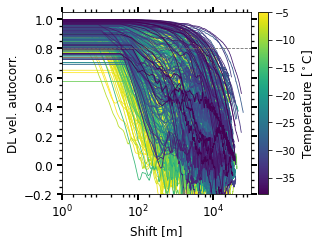

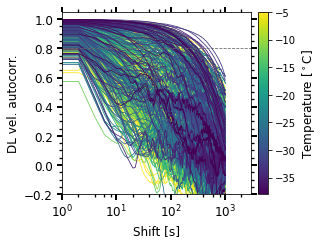

In [37]:
fig, ax = plot_autocorr(clouds_standard['ice_producing'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_ice_prod.png'
fig.savefig(fname, dpi=250)

fig, ax = plot_autocorr(clouds_standard['ice_producing'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_autocorrelation_s_ice_prod.png'
fig.savefig(fname, dpi=250)

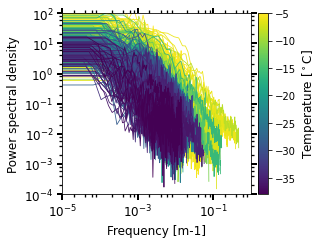

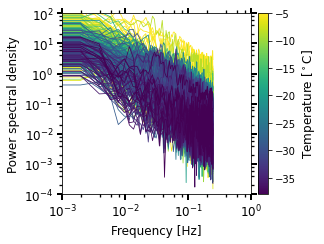

In [38]:
fig, ax = plot_periodogram(clouds_standard['ice_producing'], hvel_corr=True)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_ice_prod.png'
fig.savefig(fname, dpi=250)


fig, ax = plot_periodogram(clouds_standard['ice_producing'], hvel_corr=False)
fig.tight_layout()
fname = f'../plots/v_timeseries/{larda_name}_dl_vel_periodogram_s_ice_prod.png'
fig.savefig(fname, dpi=250)


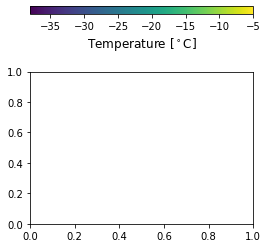

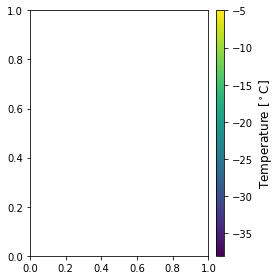

In [39]:

    
fig, axes = plt.subplots(figsize=[4,4])

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_vertical(size="5%", pad=0.8)    

cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

plt.gcf().add_axes(ax_cb)

cb1.set_label('Temperature [$^\circ$C]', fontsize=12)

fname = f'../plots/v_timeseries/colorbar_hor_single.png'
fig.savefig(fname, dpi=250)


fig, axes = plt.subplots(figsize=[4,4])

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=-38.0, vmax=-5.0)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.1)    


cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.gcf().add_axes(ax_cb)

cb1.set_label('Temperature [$^\circ$C]', fontsize=12)
fig.tight_layout()
fname = f'../plots/v_timeseries/colorbar_ver_single.png'
fig.savefig(fname, dpi=250)